## TUMOR DETECTOR FROM MRI SCANS ##

In [12]:
# Dataset link: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset (ctrl + click)

In [13]:
## Packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from keras.src.backend.jax.numpy import squeeze, outer
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


import glob 
import cv2

## Fetch function ##

In [14]:
def fetchAppend(path, li):
	for file in glob.iglob(path):
		img = cv2.imread(file)
		img = cv2.resize(img, (128, 128))
		b, g, r = cv2.split(img)
		img = cv2.merge([r, g, b])
		li.append(img)
	return np.array(li)

## Helper functions ##

In [15]:
# returns dataset attributes
def shape(arr):
	rows, Xpixels, Ypixels, layers = arr.shape
	return f"Rows: {rows} Size: {Xpixels}x{Ypixels} Layers: {layers}"

In [16]:
# plots images
def plot_img(arr, num, name):
	var = arr[np.random.choice(arr.shape[0], num, replace=False)]
	plt.figure(figsize=(16, 9))
	for i in range(num):
		plt.subplot(1, num, i + 1)
		plt.title(name)
		plt.imshow(var[i])
		plt.axis('off')

In [17]:
# plots images from Dataset Class, training set
def plot_img_MRI_train(MRI):
	label_info = {
		0: ('No Tumor',   0,    1594),
		1: ('Glioma',     1595, 2915),
		2: ('Meningioma', 2916, 4254),
		3: ('Pituitary',  4255, 5711)
	}
	plt.figure(figsize=(16, 9))
	for i, (label, (name, l, r)) in enumerate(label_info.items()):
		idx = np.random.randint(l, r)
		ins = MRI[idx]
		img = ins['image']
		if img.shape[0] == 1:
			img_to_show = img[0]
		else:
			img_to_show = np.transpose(img, (1, 2, 0))
		plt.subplot(1, 4, i + 1)
		plt.title(name)
		plt.imshow(img_to_show)
		plt.axis('off')

## Label Mapping & Threshold Function ##

In [18]:
label = {
	0: 'No Tumor',
	1: 'Glioma',
	2: 'Meningioma',
	3: 'Pituitary'
}

In [19]:
def threshold(arr):
	if not isinstance(arr, np.ndarray):
		arr = np.array(list(arr))
	x = arr
	x[(x >= 0) & (x <= 0.25)] = 0
	x[(x > 0.25) & (x <= 0.5)] = 1
	x[(x > 0.5) & (x <= 0.75)] = 2
	x[(x > 0.75) & (x <= 1)] = 3
	return x.astype(np.float32)

## Training Data fetching ##

In [20]:
# Glioma
glioma_training_path = './Training/glioma/*.jpg'
glioma_train = fetchAppend(glioma_training_path, [])

In [21]:
# Meningioma
meningioma_training_path = './Training/meningioma/*.jpg'
meningioma_train = fetchAppend(meningioma_training_path, [])

In [22]:
# Pituitary Adenoma
pituitary_training_path = './Training/pituitary/*.jpg'
pituitary_train = fetchAppend(pituitary_training_path, [])

In [23]:
# Healthy
notumor_training_path = './Training/notumor/*.jpg'
notumor_train = fetchAppend(notumor_training_path, [])

In [24]:
print(f"Glioma:\t\t {shape(glioma_train)} \nMeningioma:\t {shape(meningioma_train)} \nPituitary:\t {shape(pituitary_train)} \nNoTumor:\t {shape(notumor_train)}")

Glioma:		 Rows: 1321 Size: 128x128 Layers: 3 
Meningioma:	 Rows: 1339 Size: 128x128 Layers: 3 
Pituitary:	 Rows: 1457 Size: 128x128 Layers: 3 
NoTumor:	 Rows: 1595 Size: 128x128 Layers: 3


In [25]:
train = np.concatenate((glioma_train, meningioma_train, pituitary_train, notumor_train), axis=0)

In [26]:
print(f"All training data:\t {shape(train)}")

All training data:	 Rows: 5712 Size: 128x128 Layers: 3


## Testing Data Fetching ##

In [27]:
# Glioma
glioma_testing_path = './Testing/glioma/*.jpg'
glioma_test = fetchAppend(glioma_testing_path, [])

In [28]:
# Meningioma
meningioma_testing_path = './Testing/meningioma/*.jpg'
meningioma_test = fetchAppend(meningioma_testing_path, [])

In [29]:
# Pituitary Adenoma
pituitary_testing_path = './Testing/pituitary/*.jpg'
pituitary_test = fetchAppend(pituitary_testing_path, [])

In [30]:
# Healthy
notumor_testing_path = './Testing/notumor/*.jpg'
notumor_test = fetchAppend(notumor_testing_path, [])

In [31]:
print(f"Glioma:\t\t {shape(glioma_test)} "
	  f"\nMeningioma:\t {shape(meningioma_test)} "
	  f"\nPituitary:\t {shape(pituitary_test)} "
	  f"\nNoTumor:\t {shape(notumor_test)}")

Glioma:		 Rows: 300 Size: 128x128 Layers: 3 
Meningioma:	 Rows: 306 Size: 128x128 Layers: 3 
Pituitary:	 Rows: 300 Size: 128x128 Layers: 3 
NoTumor:	 Rows: 405 Size: 128x128 Layers: 3


In [32]:
test = np.concatenate((glioma_test, meningioma_test, pituitary_test, notumor_test), axis=0)
print(f"All testing data:\t {shape(test)}")

All testing data:	 Rows: 1311 Size: 128x128 Layers: 3


## Visualizing MRI IMAGES (Trainset) ##

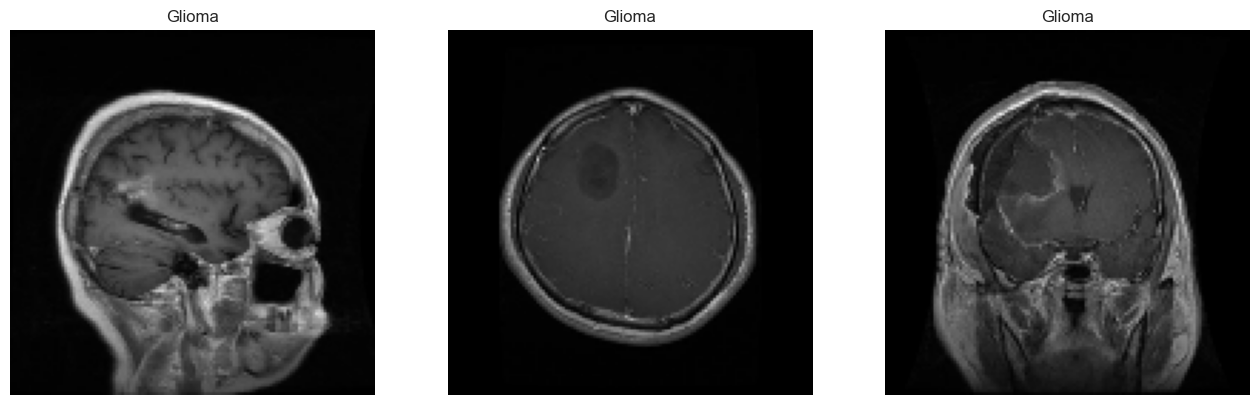

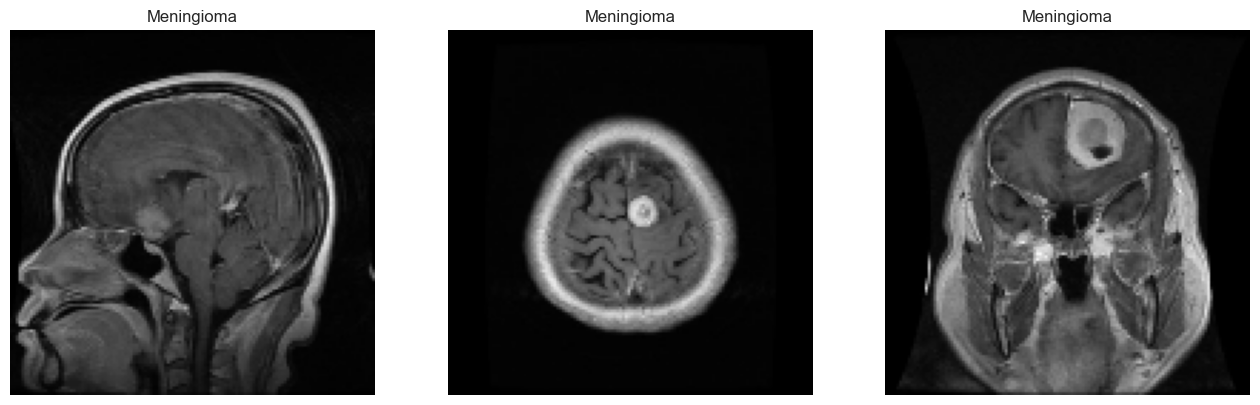

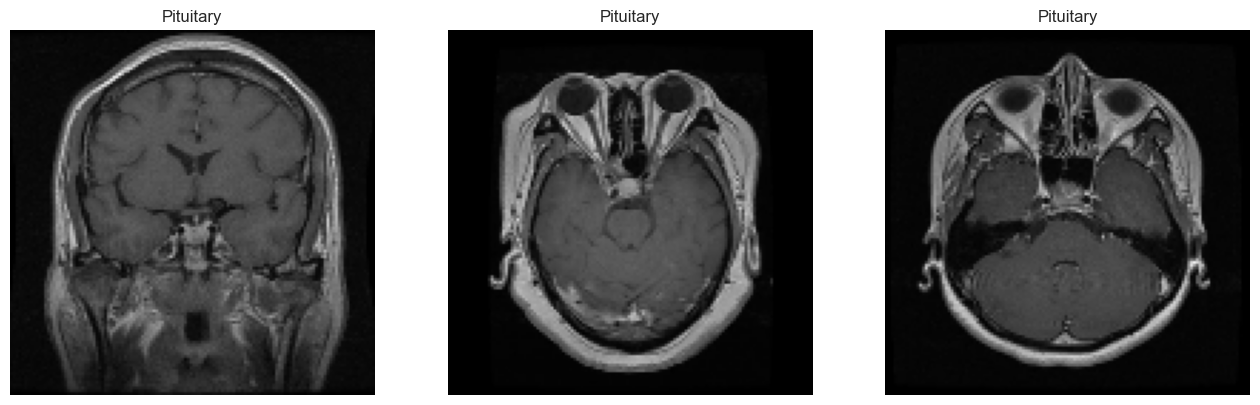

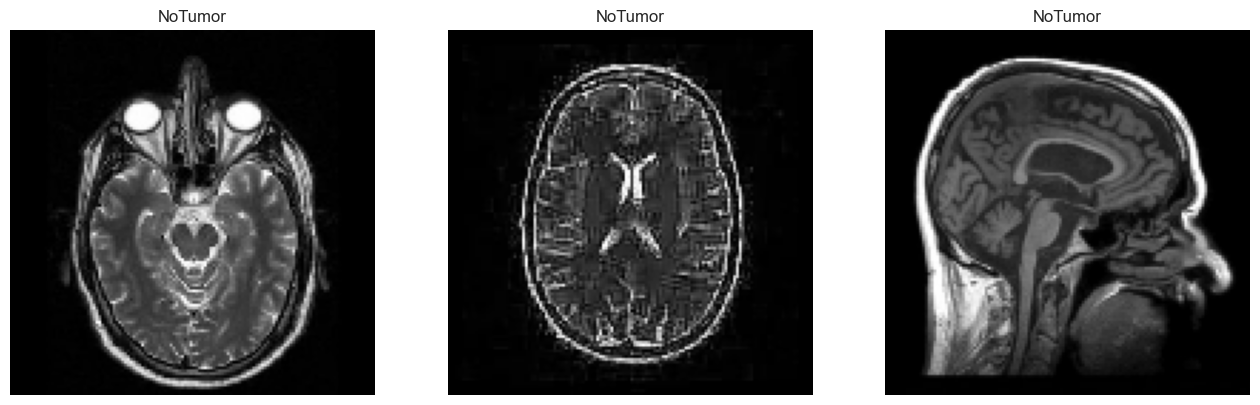

In [33]:
plot_img(glioma_train, 3, 'Glioma')
plot_img(meningioma_train, 3, 'Meningioma')
plot_img(pituitary_train, 3, 'Pituitary')
plot_img(notumor_train, 3, 'NoTumor')

## Visualizing MRI IMAGES (Testset) ##

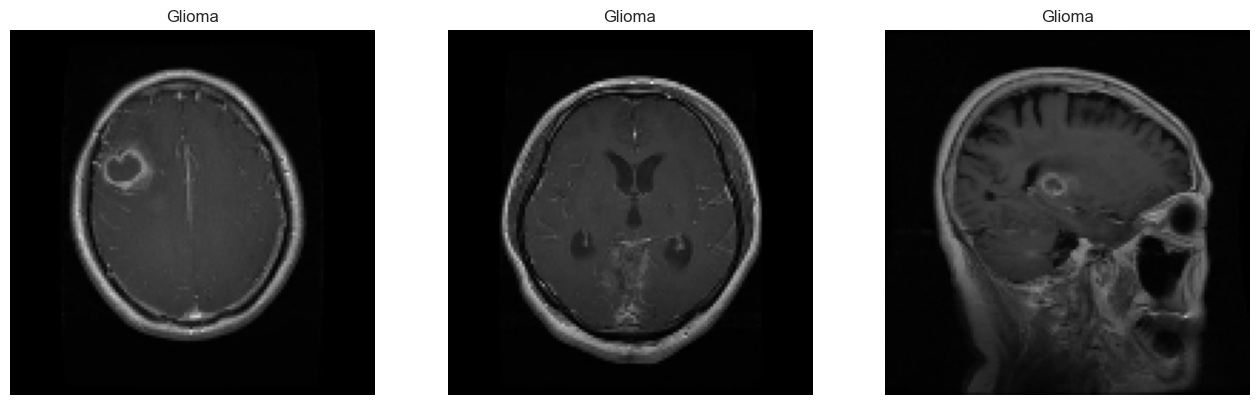

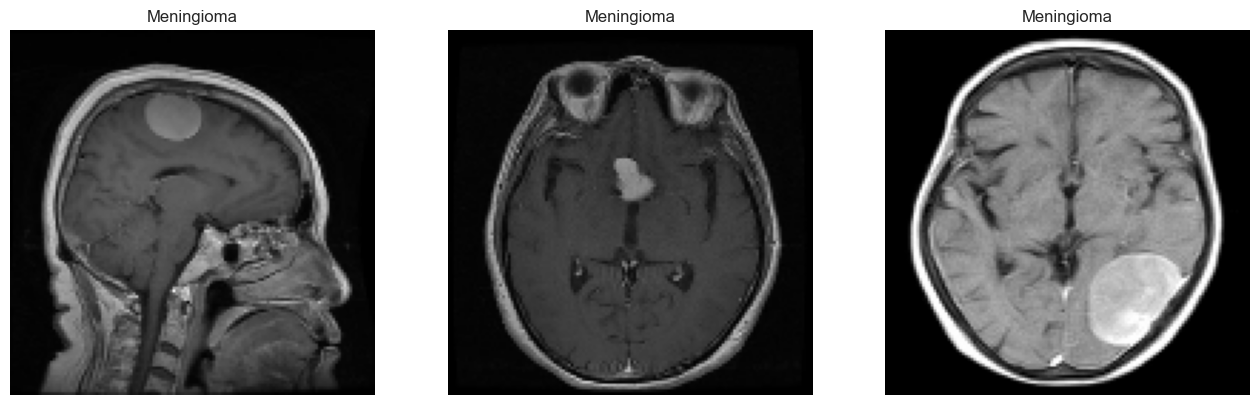

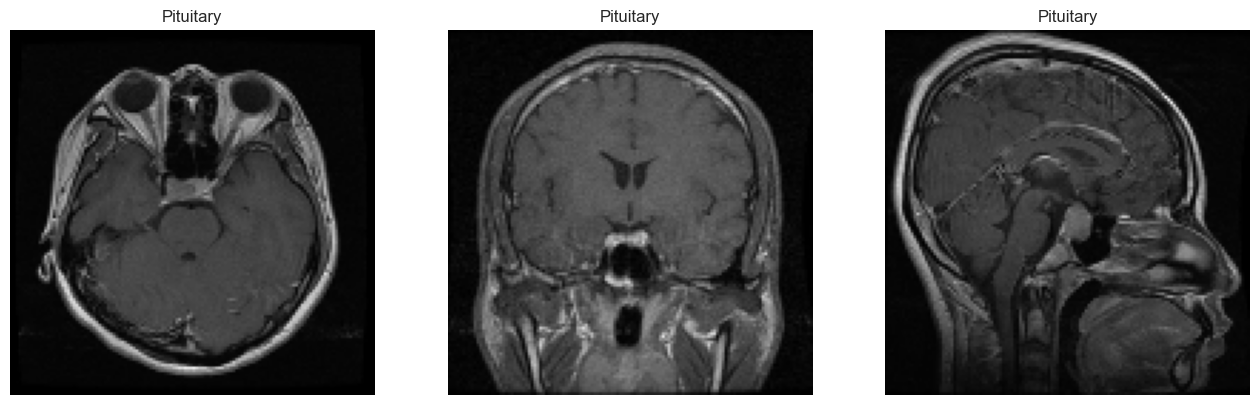

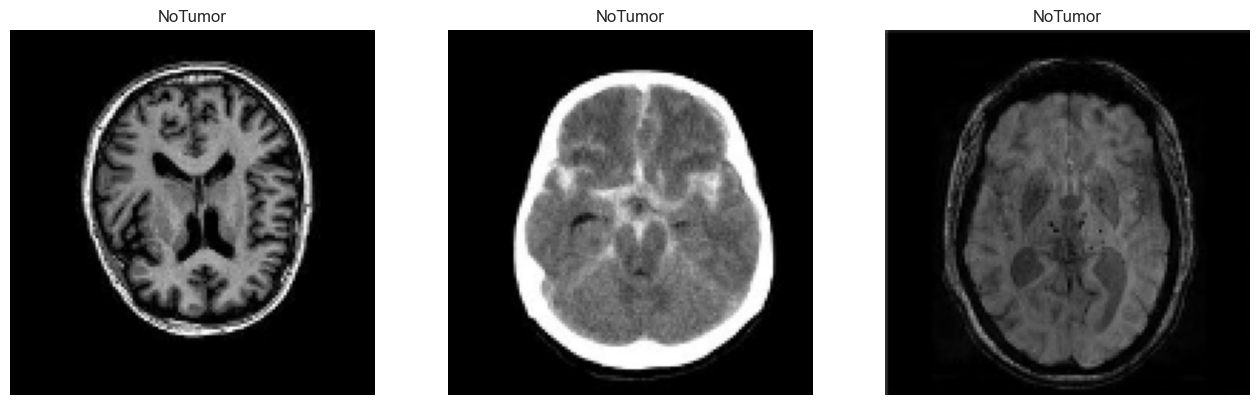

In [34]:
plot_img(glioma_test, 3, 'Glioma')
plot_img(meningioma_test, 3, 'Meningioma')
plot_img(pituitary_test, 3, 'Pituitary')
plot_img(notumor_test, 3, 'NoTumor')

## Pytorch Dataset Class ##

In [35]:
# noinspection PyShadowingNames
class MRI:
	def __init__(self, images, label=None):
		self.images = images.astype(np.float32)
		if label is None:
			self.labels = np.zeros(images.shape[0], dtype=np.float32)
		else:
			self.labels = np.array([label]*images.shape[0] , dtype=np.float32)
		
	def __getitem__(self, index):
		img = self.images[index]
		img = np.transpose(img, (2, 0, 1))
		instance = {
			'image': img,
			'label': self.labels[index]
		}
		return instance
	
	def __len__(self):
		return self.images.shape[0]
	
	def __add__(self, other):
		if not isinstance(other, MRI):
			raise TypeError("No concatenation here for class objects other than MRI")
		new_images = np.concatenate((self.images, other.images), axis=0)
		new_labels = np.concatenate((self.labels, other.labels), axis=0)
		merged = MRI(new_images)
		merged.labels = new_labels
		return merged
	
	def normalize(self):
		# sets value between 0-1
		if np.max(self.images) <= 1:
			pass
		self.images = self.images/255.0

In [36]:
# label mapping
notumor_label = 0
glioma_label = 1
meningioma_label = 2
pituitary_label = 3

In [37]:
# NoTumor Dataset
notumorTrain = MRI(notumor_train, notumor_label)
notumorTest = MRI(notumor_test, notumor_label)

In [38]:
# Glioma Dataset
gliomaTrain = MRI(glioma_train, glioma_label)
gliomaTest = MRI(glioma_test, glioma_label)

In [39]:
# Meningioma Dataset
meningiomaTrain = MRI(meningioma_train, meningioma_label)
meningiomaTest = MRI(meningioma_test, meningioma_label)

In [40]:
# Pituitary Dataset
pituitaryTrain = MRI(pituitary_train, pituitary_label)
pituitaryTest = MRI(pituitary_test, pituitary_label)

In [41]:
trainset = notumorTrain + gliomaTrain + meningiomaTrain + pituitaryTrain
testset = notumorTest + gliomaTest + meningiomaTest + pituitaryTest

In [42]:
print(len(trainset), 
	  len(testset))

5712 1311


In [43]:
# standard practice to normalize dataset before training NN model
trainset.normalize()
testset.normalize()

## MRI Class Visualization ##

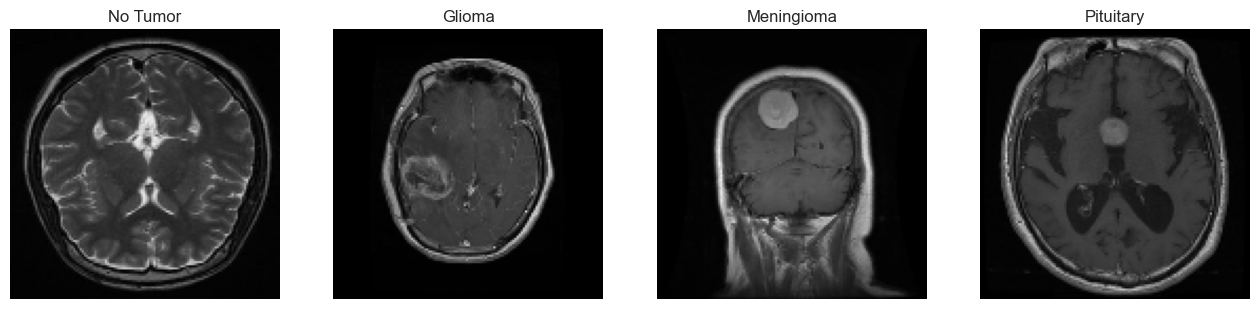

In [44]:
plot_img_MRI_train(trainset)

## CNN Model Creation using PyTorch ##

In [45]:
class CNN(nn.Module):
	def __init__(self):
		super(CNN, self).__init__()
		self.cnn_model = nn.Sequential(
			# 1st conv layer
			nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
			nn.Tanh(),
			nn.AvgPool2d(kernel_size=2, stride=5),
			# 2nd conv layer
			nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
			nn.Tanh(),
			nn.AvgPool2d(kernel_size=2, stride=5),
		)
		self.fc_model = nn.Sequential(
			# 1st linear layer
			nn.Linear(in_features=256, out_features=120),
			nn.Tanh(),
			# 2nd linear layer
			nn.Linear(in_features=120, out_features=84),
			nn.Tanh(),
			# 3rd linear layer
			nn.Linear(in_features=84, out_features=4)
		)
	
	def forward(self, x):
		x = self.cnn_model(x)
		x = x.view(x.size(0), -1)
		x = self.fc_model(x)
		return x

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model Training ##

In [47]:
cnn = CNN()
cnn = cnn.to(device)
EPOCH = 400
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)

g = torch.Generator()
g.manual_seed(42)
train_dl = DataLoader(trainset, shuffle=True, batch_size=32, generator=g)   # For reproducibility

criterion = nn.CrossEntropyLoss()

In [48]:
cnn.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=4, bias=True)
  )
)

In [49]:
best_loss = 10
for epoch in range(1, EPOCH + 1):
	losses = []
	for ins in train_dl:
		optimizer.zero_grad()
		img = ins['image'].to(device)
		label = ins['label'].long().to(device)
		y_hat = cnn(img)
		loss = criterion(y_hat, label)
		loss.backward()
		optimizer.step()
		losses.append(loss.item())
	epoch_loss = np.mean(losses)
	# save best model after each epoch
	if epoch_loss < best_loss:
		best_loss = epoch_loss
		torch.save({
			'epoch': epoch,
			'model_state_dict': cnn.state_dict(),
			'optimizer_state_dict': optimizer.state_dict(),
			'loss': best_loss
		}, 'tumor_detector.pth')
	# print loss every 10 epoch
	if (epoch + 1) % 10 == 0:
		print(f'Train Epoch: {epoch+1} \tLoss: {epoch_loss:4f}')

Train Epoch: 10 	Loss: 0.685700
Train Epoch: 20 	Loss: 0.553982
Train Epoch: 30 	Loss: 0.497741
Train Epoch: 40 	Loss: 0.446609
Train Epoch: 50 	Loss: 0.411153
Train Epoch: 60 	Loss: 0.381049
Train Epoch: 70 	Loss: 0.358559
Train Epoch: 80 	Loss: 0.337767
Train Epoch: 90 	Loss: 0.315939
Train Epoch: 100 	Loss: 0.292938
Train Epoch: 110 	Loss: 0.275424
Train Epoch: 120 	Loss: 0.255087
Train Epoch: 130 	Loss: 0.237390
Train Epoch: 140 	Loss: 0.223400
Train Epoch: 150 	Loss: 0.202077
Train Epoch: 160 	Loss: 0.196824
Train Epoch: 170 	Loss: 0.178747
Train Epoch: 180 	Loss: 0.158661
Train Epoch: 190 	Loss: 0.142211
Train Epoch: 200 	Loss: 0.130704
Train Epoch: 210 	Loss: 0.119099
Train Epoch: 220 	Loss: 0.110747
Train Epoch: 230 	Loss: 0.098169
Train Epoch: 240 	Loss: 0.086439
Train Epoch: 250 	Loss: 0.077017
Train Epoch: 260 	Loss: 0.066111
Train Epoch: 270 	Loss: 0.056883
Train Epoch: 280 	Loss: 0.050732
Train Epoch: 290 	Loss: 0.040214
Train Epoch: 300 	Loss: 0.033377
Train Epoch: 310 	L

## Model Testing ##

In [50]:
cnn = CNN().to(device)
checkpoint = torch.load('tumor_detector.pth', weights_only=False)
cnn.load_state_dict(checkpoint['model_state_dict'])
cnn.eval()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=4, bias=True)
  )
)

In [51]:
test_dl = DataLoader(testset, shuffle=False, batch_size=32)

In [52]:
y_pred = []
y_true = []

with torch.no_grad():
	for ins in test_dl:
		img = ins['image'].to(device)
		label = ins['label'].long().to(device)
		
		y_hat = cnn(img)
		y_hat = torch.argmax(y_hat, dim=1)
		y_pred.append(y_hat.cpu().detach().numpy())
		y_true.append(label.cpu().detach().numpy())
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

In [55]:
accuracy_score(y_true, y_pred)

0.9588100686498856

In [56]:
cr = classification_report(y_true, y_pred, 
					  target_names=['NoTumor', 'Glioma', 'Meningioma', 'Pituitary'], 
					  output_dict=True)

In [57]:
cr_pd = pd.DataFrame(cr)
cr_pd = cr_pd.T
cr_pd = cr_pd.drop(columns=['support'])
print(cr_pd)

              precision    recall  f1-score
NoTumor        0.975845  0.997531  0.986569
Glioma         0.964912  0.916667  0.940171
Meningioma     0.921311  0.918301  0.919804
Pituitary      0.967427  0.990000  0.978583
accuracy       0.958810  0.958810  0.958810
macro avg      0.957374  0.955625  0.956282
weighted avg   0.958688  0.958810  0.958540


In [58]:
print(f"Accuracy: {cr_pd.loc['accuracy', 'precision']:.4f}\n"
	  f"Precision: {cr_pd['precision']['macro avg']:.4f} (avg)\n"
	  f"Recall: {cr_pd['recall']['macro avg']:.4f} (avg)\n"
	  f"F1-score: {cr_pd['f1-score']['macro avg']:.4f} (avg)")

Accuracy: 0.9588
Precision: 0.9574 (avg)
Recall: 0.9556 (avg)
F1-score: 0.9563 (avg)


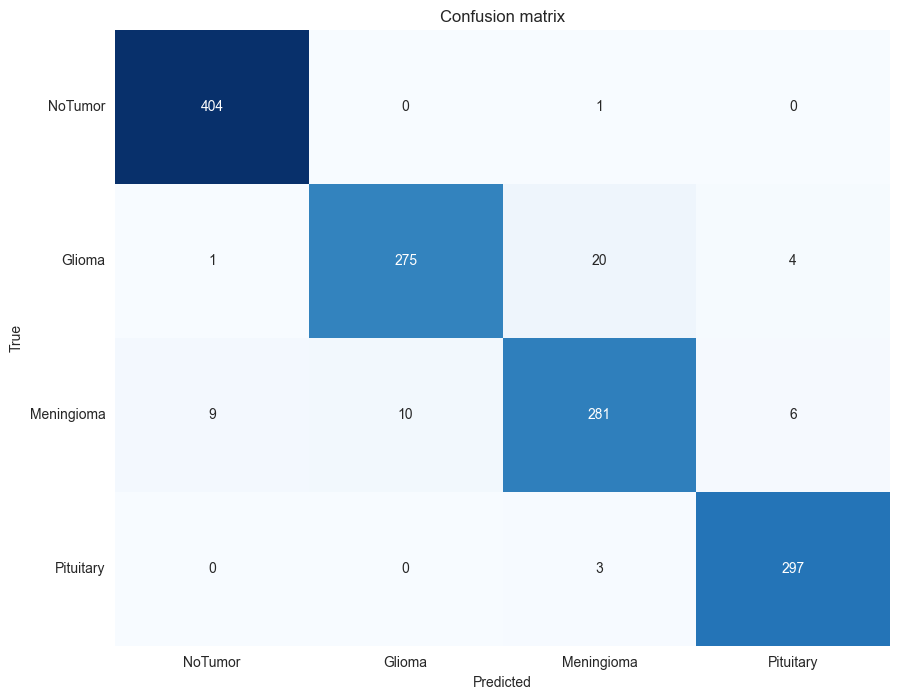

In [59]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=cm, cmap='Blues', cbar=False, fmt='d', 
			xticklabels=['NoTumor', 'Glioma', 'Meningioma', 'Pituitary'],
			yticklabels=['NoTumor', 'Glioma', 'Meningioma', 'Pituitary'])
plt.xticks(rotation=0)
plt.xlabel('Predicted')
plt.yticks(rotation=0)
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()